# Анализ оттока клиентов сети фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

Цель проекта — проанализировать поведение клиентов на основе клиентских анкет и подготовить план действий по их удержанию.

Задачи:
- научиться прогнозировать вероятность оттока для каждого клиента;
- сформировать типичные портреты клиентов и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

## Изучение и предобработка данных

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

Структура gym_churn.csv:
- 'Churn' — факт оттока в текущем месяце;
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба;
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга»;
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра.

In [3]:
display(df.sample(10, random_state=1))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
200,0,1,1,0,1,1,0,34,46.492200,1.0,0,1.010771,0.000000,1
1078,1,1,0,0,1,1,0,27,24.553945,1.0,4,1.390535,0.979445,1
610,1,1,1,1,1,6,1,31,85.671887,6.0,1,1.009510,0.730576,1
2159,1,0,1,0,1,1,0,26,75.803228,1.0,1,1.457390,1.540269,1
1169,0,0,0,0,1,1,0,31,410.756733,1.0,3,2.401838,2.473404,0
2448,0,0,0,0,1,12,1,28,106.110097,10.0,3,2.558573,2.520852,0
2938,1,1,0,0,0,1,0,23,199.155395,1.0,0,2.947225,2.701548,1
813,1,1,1,1,1,6,1,34,115.869242,4.0,9,0.652474,0.570673,0
1268,0,1,0,1,1,1,0,29,158.981864,1.0,2,1.775618,0.705410,1
870,0,1,0,0,1,1,1,32,67.587775,1.0,4,1.216622,1.333863,0


Приведём названия столбцов к нижнему регистру.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [6]:
df.duplicated().sum()

0

Пропусков и дубликатов нет.

### Вывод

При изучении файлов были выявлены следующие пункты:
- названия в столбцах необходимо привести к нижнему регистру;
- пропуски и повторяющиеся строки не были найдены;
- типы данных корректные.

## Исследовательский анализ данных (EDA)

In [7]:
df.shape

(4000, 14)

В файле 14 столбцов и 4000 записей.

Изучим средние значения и стандартные отклонения с помощью метода describe().

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Никаких аномалий в данных не обнаружено.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток (1) и тех, кто остался (0). Для этого воспользуйемся методом groupby().

In [9]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Из полученных данных видно, что на факт оттока не влияют или влияют незначительно следующие признаки:
- пол;
- наличие контактного телефона;
- проживание или работа рядом с фитнес-центром.

Остальные признаки могут влиять более значительно.

Построим графики для признаков в зависимости от факта оттока клиентов.

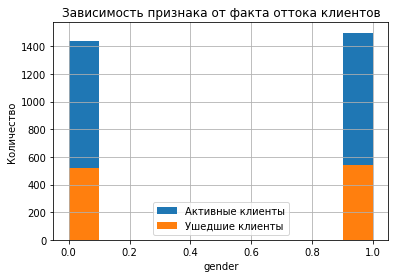

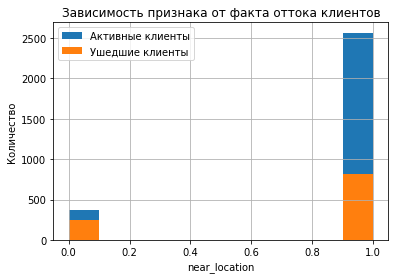

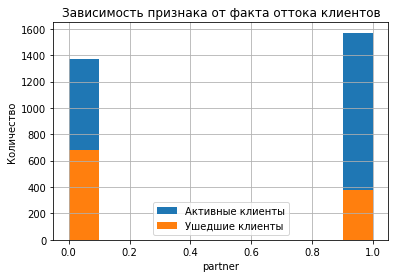

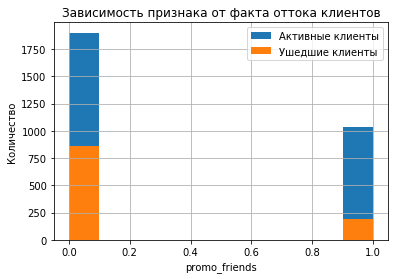

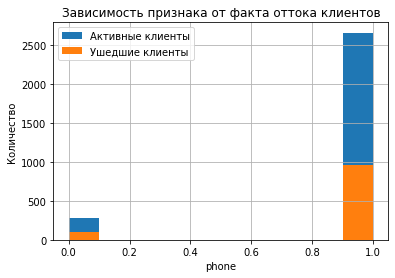

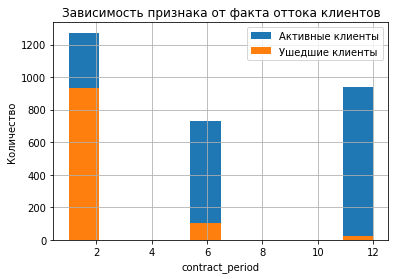

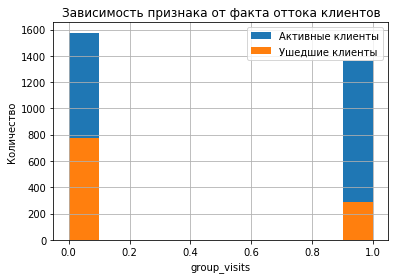

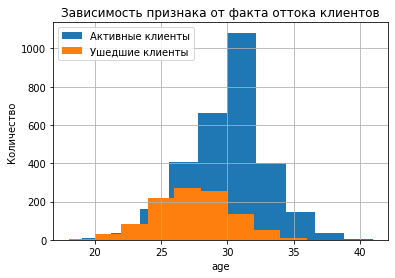

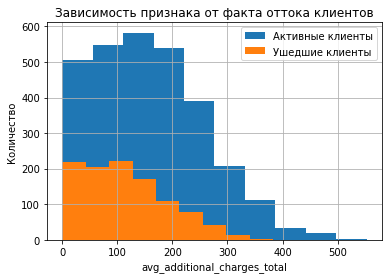

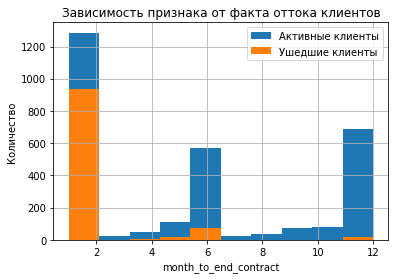

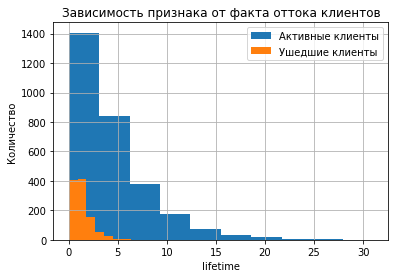

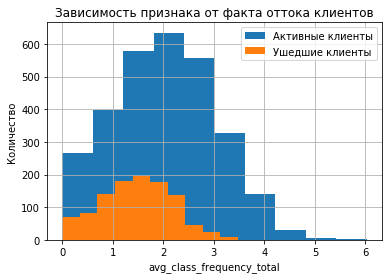

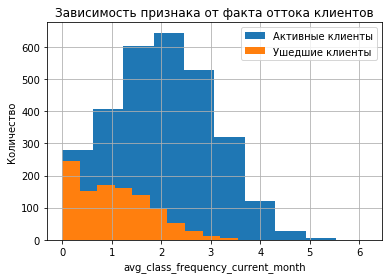

In [10]:
for i in df.drop('churn', axis=1).columns:
    df.query('churn == 0')[i].hist(bins=10, label='Активные клиенты')
    df.query('churn == 1')[i].hist(bins=10, label='Ушедшие клиенты')
    plt.title('Зависимость признака от факта оттока клиентов')
    plt.xlabel(i)
    plt.ylabel('Количество')
    plt.legend()
    plt.show()

На полученных графиках также видно, что пол и наличие телефона почти не влияют на уход клиентов.
Остальные признаки влияют более значительно. Например:
- если у клиента краткосрочный абонемент, то он вероятнее перестанет заниматься;
- те, кто не посещают групповые занятия, чаще перестают заниматься;
- средний возраст ушедших клиентов около 26 лет, а у активных клиентов - 30 лет;
- в основном прекращают заниматься клиенты, которые недавно приобрели абонемент (до 6 мес.).

Построим матрицу корреляций для всех признаков.

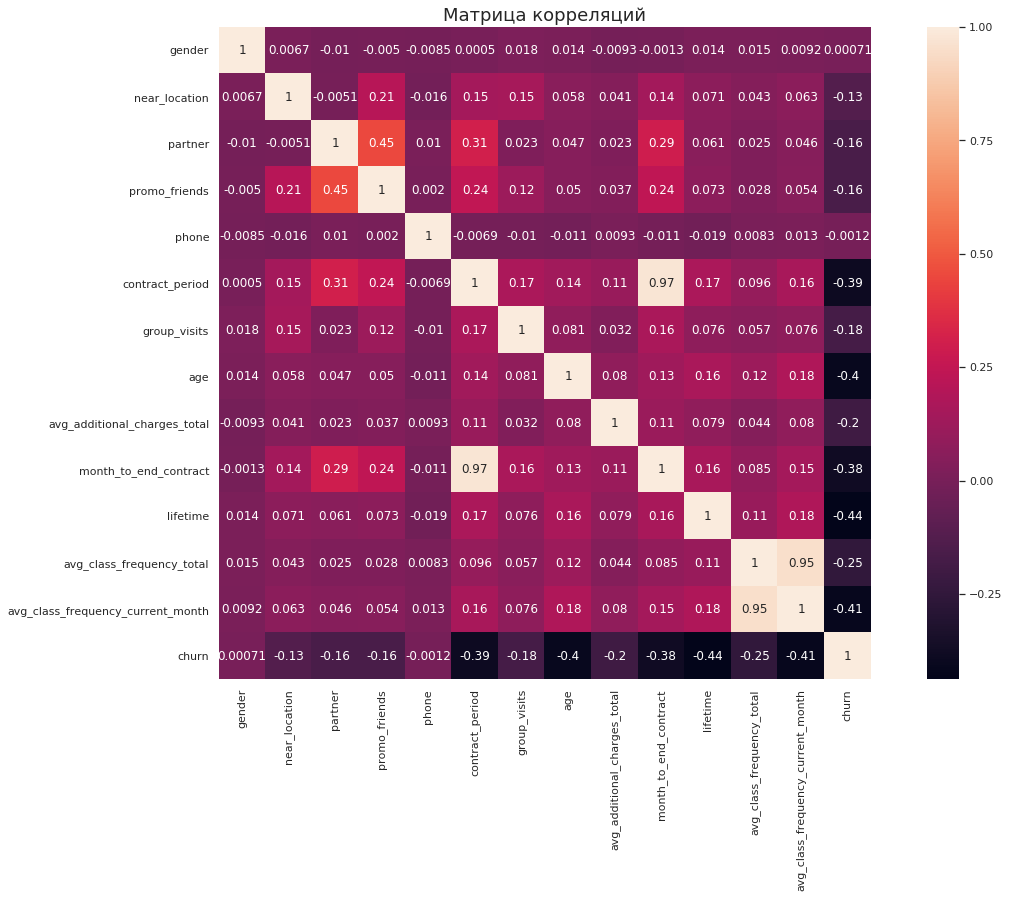

In [11]:
sns.set(style='white')
plt.figure(figsize=(20, 12))
plt.title('Матрица корреляций', fontsize=18)
sns.heatmap(df.corr(), annot=True, square = True);

Из графика видно, что наиболее взаимосвязаны признаки "длительность абонемента" и "срок до окончания абонемента", а также "частота посещений за все время абонемента" и "частота посещений за предыдущий месяц". Их коэффициенты почти равны 1 (0,97 и 0,95), но это объяснимо.
Также выделяется корреляция между признаками "сотрудник компании-партнёра" и "запись по акции "приведи друга". Возможно, что сотрудники таких компаний друг другу присылают промо-коды при покупке абонементов (корреляция 0,45).

### Вывод

При исследовании данных были получены следующие выводы:
- аномалий нет, средние значения признаков не завышены;
- признаки "пол" и "наличие телефона" не влияют на отток клиентов;
- остальные признаки имеют разное влияние на отток клиентов;
- были выявлены очевидные взаимосвязанные признаки (длительность абонемента и срок до его окончания, а также часто посещений за весь период и за предыдущий месяц).

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Сначала выделим все наши признаки в матрицу X, а целевой признак - в переменную y.
Затем разделим модель на обучающую и валидационную выборку.

In [12]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn']

In [13]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке двумя способами - логистическая регрессия и случайный лес. Также оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [14]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
# задаём алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)

# обучаем модель логистической регрессии
lr_model.fit(X_train, y_train)

# делаем прогноз
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

# выводим все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# задаём алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучаем модель случайного леса
rf_model.fit(X_train, y_train)

# вделаем прогноз
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

# выводим все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


На основании полученных метрик модель логистической регресии показывает немного лучшие результаты, чем модель случайного леса.

### Вывод

На данном этапе:
- построена модель бинарной классификации клиентов, в которой целевой признак — факт оттока клиента в следующем месяце;
- модель была обучена двумя алгоритмами: логистической регрессией и случайным лесом;
- оценены метрики accuracy, precision и recall для обеих моделей. По результатам оценки лучше оказалась модель логистической регрессии;
- обе модели показывают высокие результаты, поэтому их можно использовать в дальнейшей работе.

## Кластеризация клиентов

Проведём кластеризацию клиентов. Для этого стандартизируем наши данные и построим матрицу расстояний функцией linkage().

In [15]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(df.drop('churn', axis=1))

linked = linkage(X_sc, method = 'ward') 

Нарисуем дендрограмму.

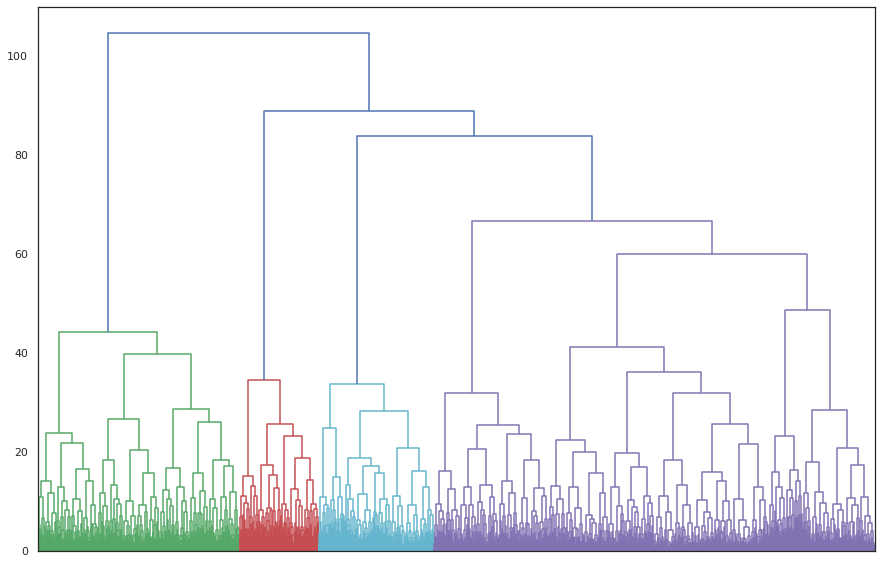

In [16]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels = True)
plt.show() 

На основании полученного графика рекомендуемое число кластеров - 4. Но при обучении модели зададим 5 кластеров

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [17]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

Посмотрим на средние значения признаков для кластеров.

In [18]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


По некоторым критериям видны различия, посмотрим на распределение признаков для кластеров. 

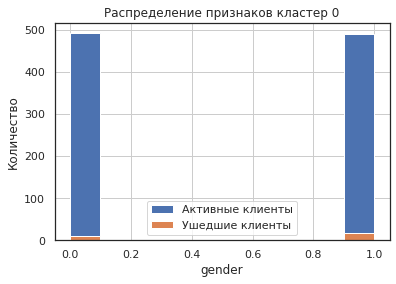

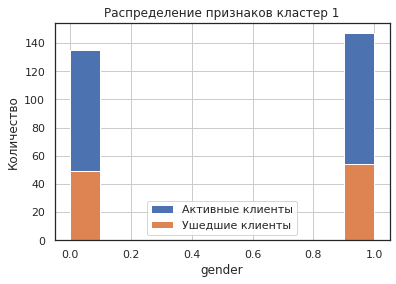

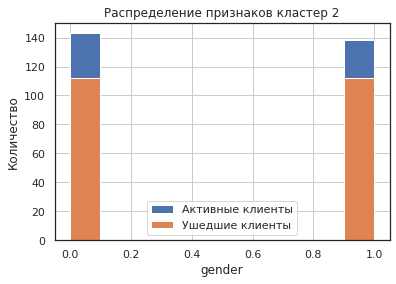

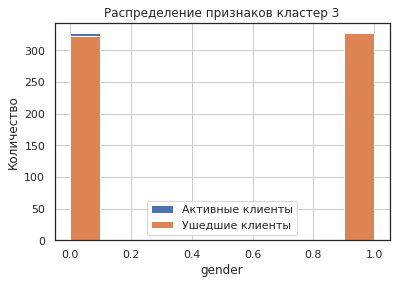

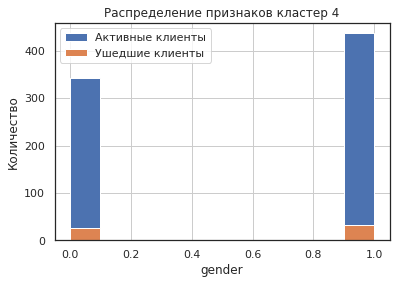

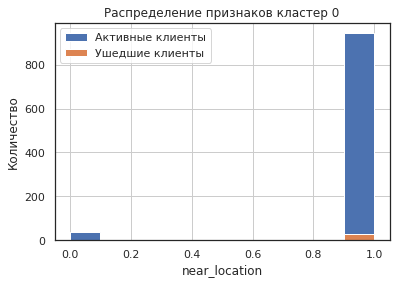

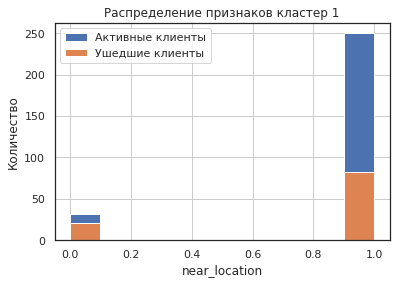

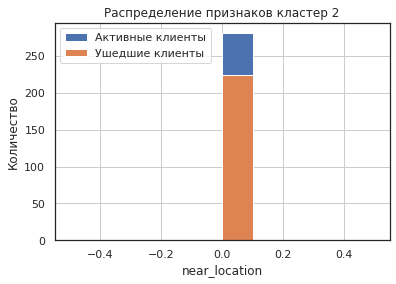

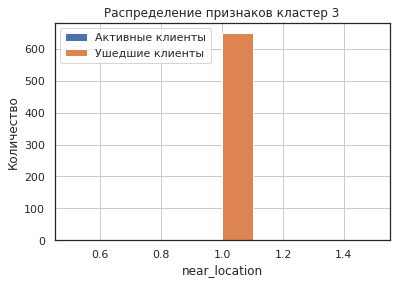

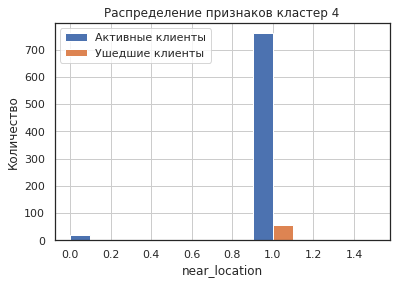

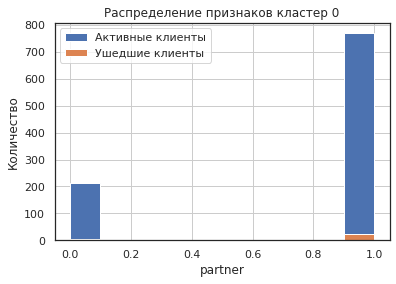

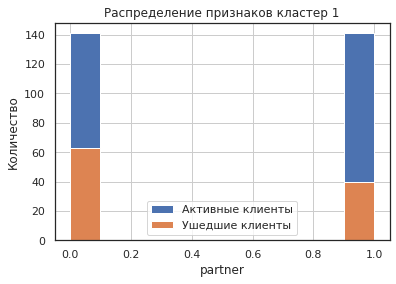

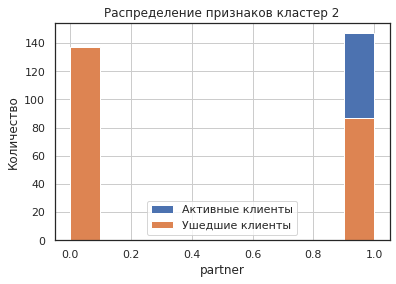

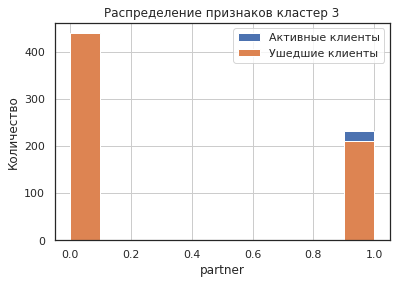

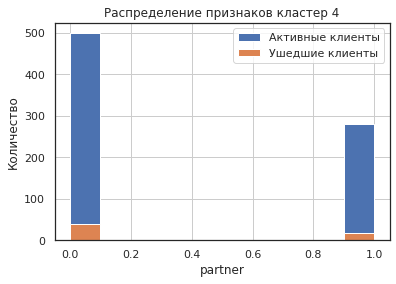

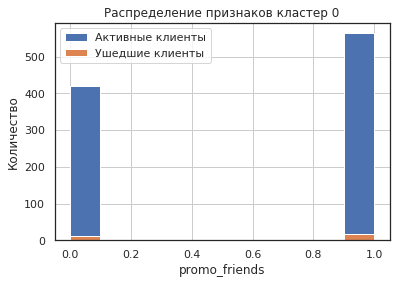

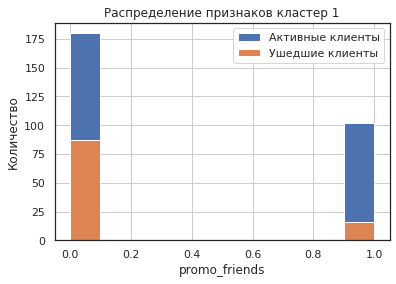

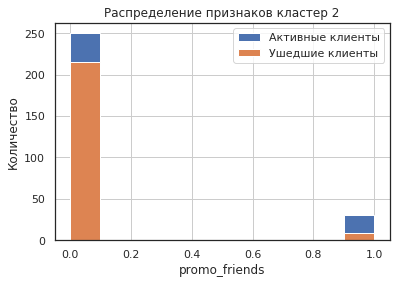

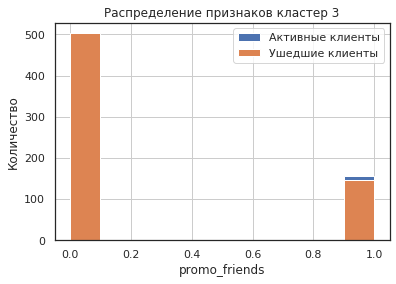

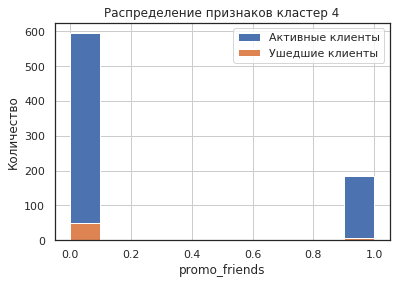

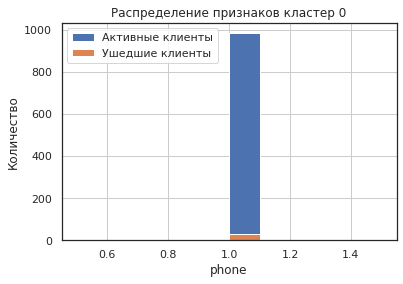

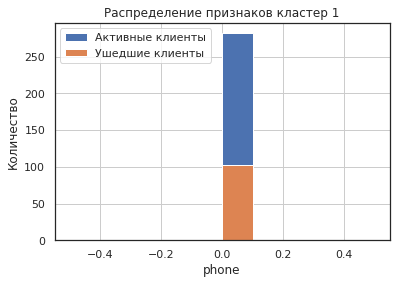

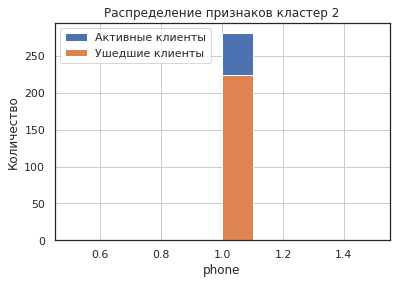

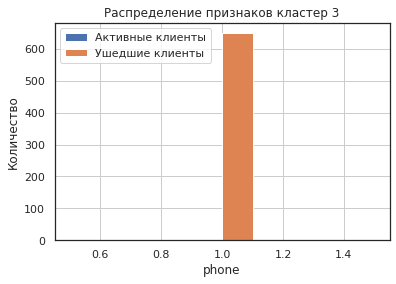

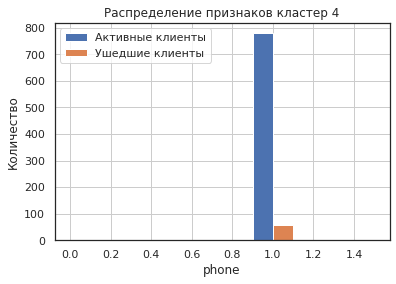

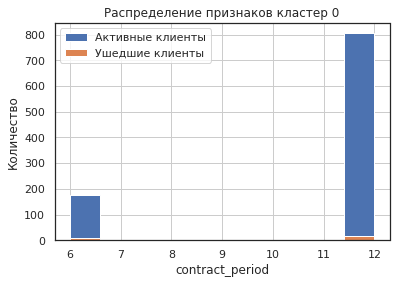

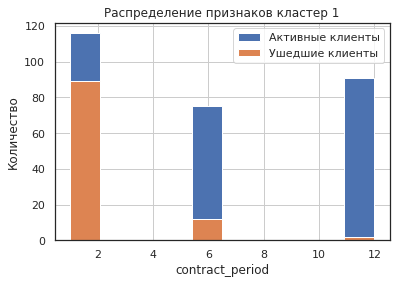

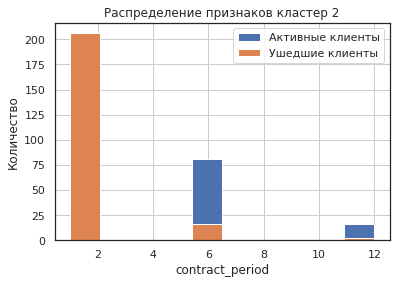

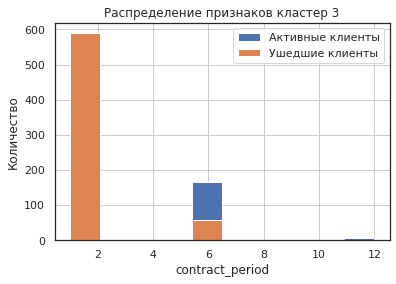

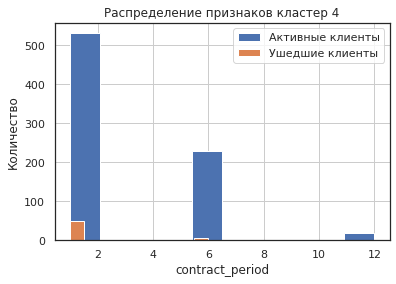

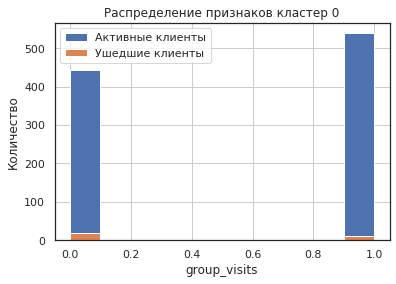

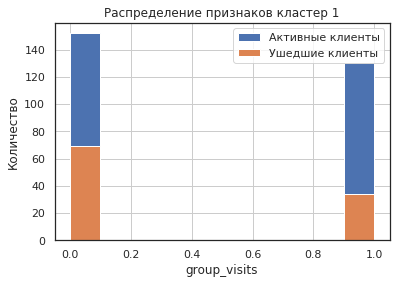

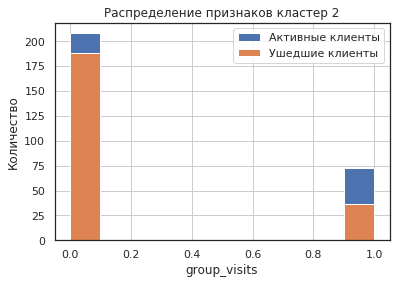

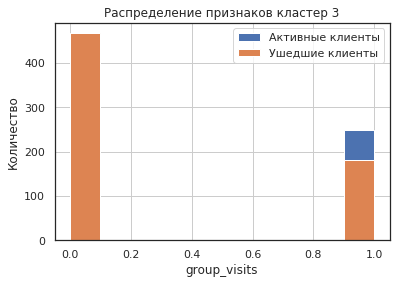

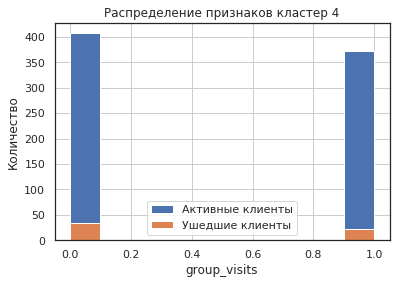

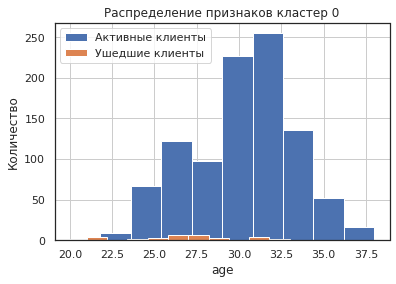

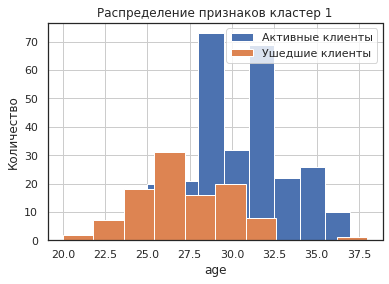

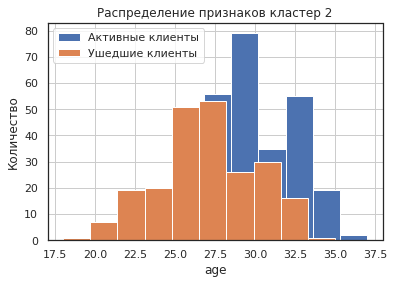

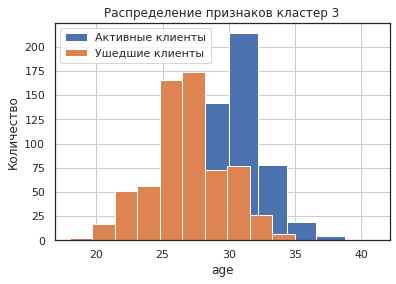

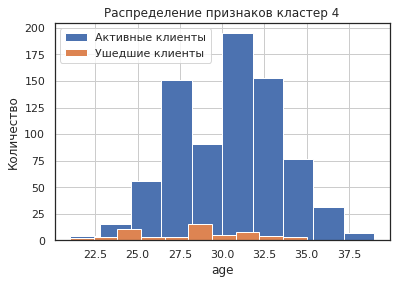

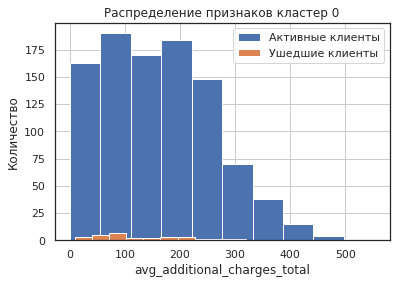

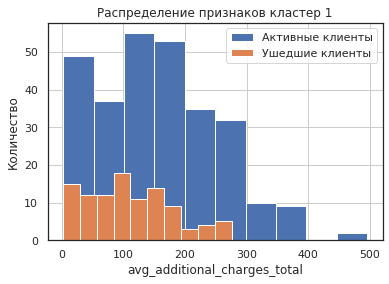

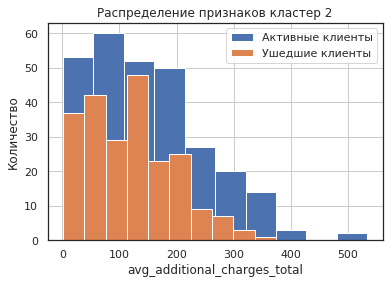

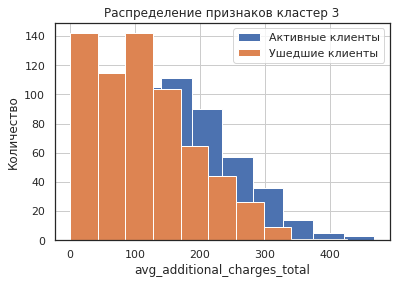

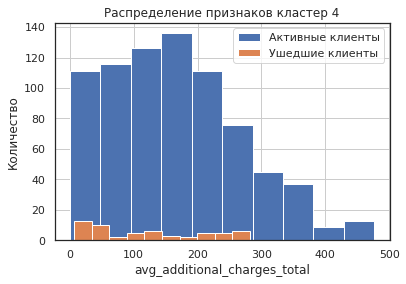

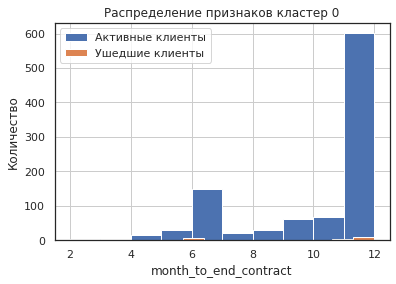

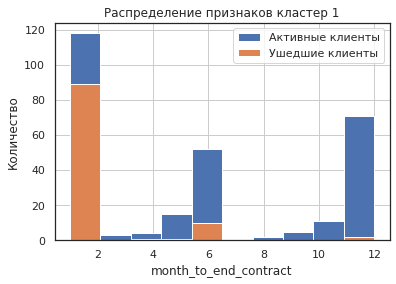

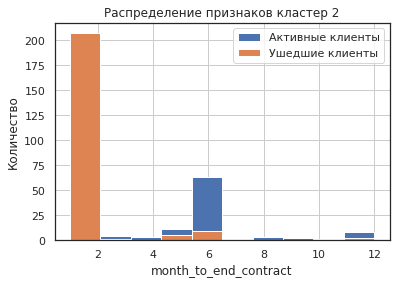

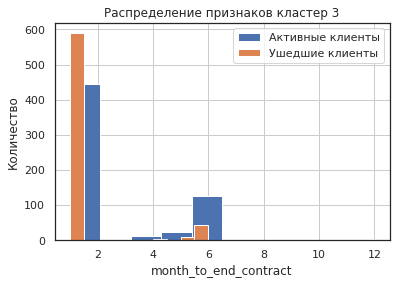

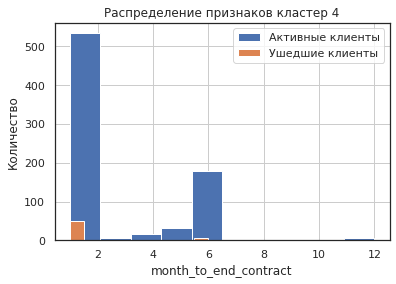

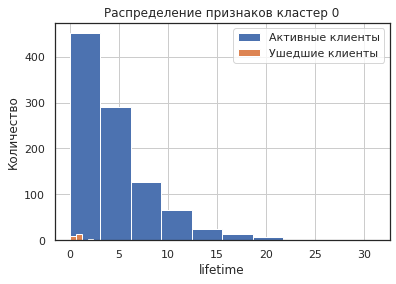

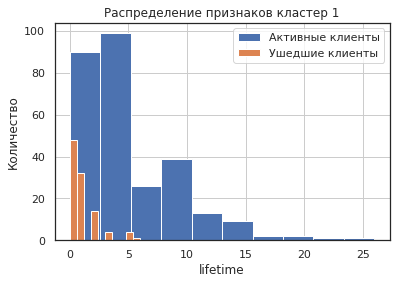

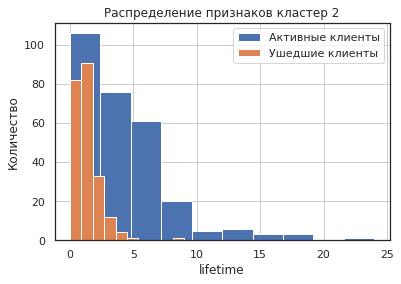

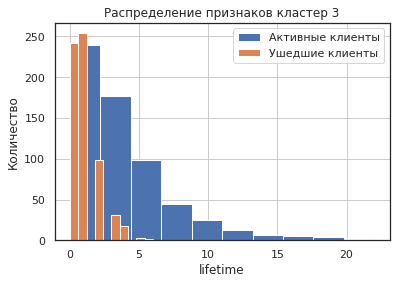

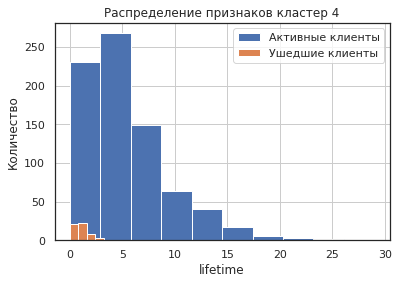

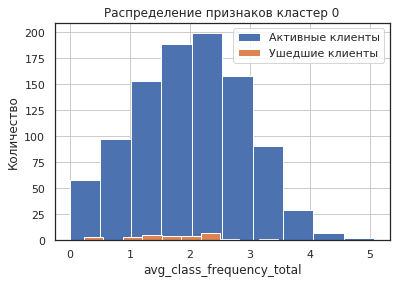

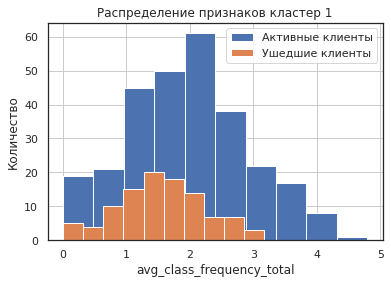

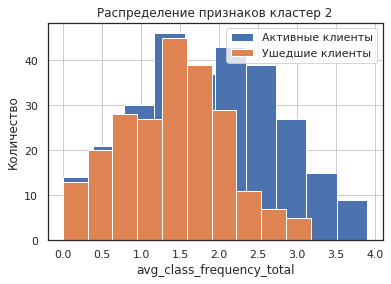

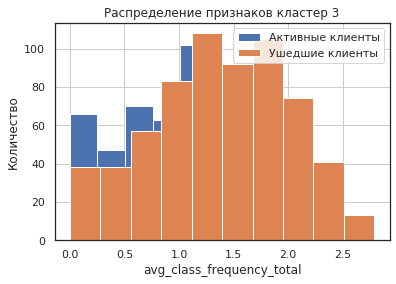

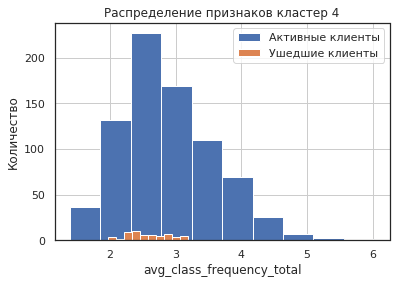

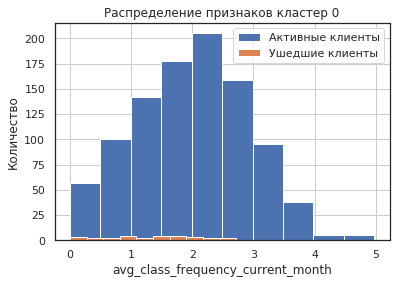

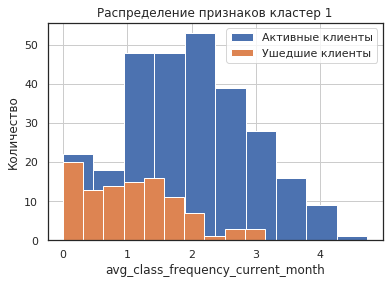

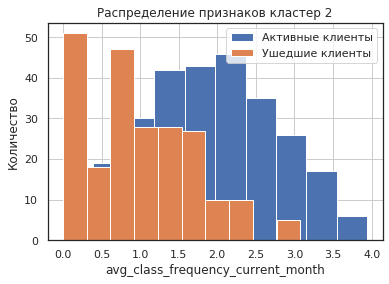

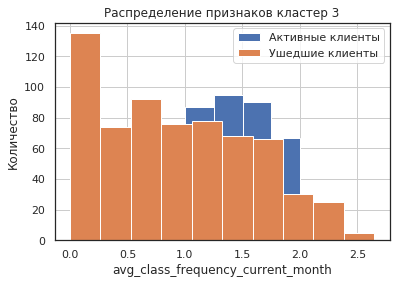

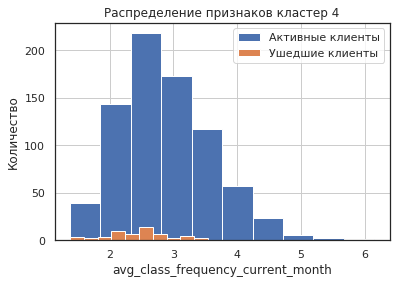

In [19]:
for i in df.drop(['churn','cluster'], axis=1).columns:        
    for l in sorted(df['cluster'].unique().tolist()):    
        df.query('churn==0 and cluster==@l')[i].hist(bins=10, label='Активные клиенты')
        df.query('churn==1 and cluster==@l')[i].hist(bins=10, label='Ушедшие клиенты')
        plt.title('Распределение признаков кластер '+ str(l))
        plt.xlabel(i)
        plt.ylabel('Количество')
        plt.legend()
        plt.show()

Клиенты кластера 2 и 3 обладают следующими признаками;
- женщин-клиентов немного больше, чем мужчин-клиентов;
- наименьшая средняя длительность абонемента;
- реже ходят на групповые занятия;
- немного моложе остальных кластеров;
- меньше тратят денег на другие услуги фитнес-центра;
- самый ранний срок начала абонемента и его окончания;
- реже всех ходили за всё время действия абонемента и за предыдущий месяц. 

Для каждого полученного кластера посчитаем долю оттока.

In [20]:
round((df.groupby(['cluster'])['churn'].sum() / df.groupby(['cluster'])['churn'].count() * 100), 2)

cluster
0     2.77
1    26.75
2    44.36
3    51.43
4     6.81
Name: churn, dtype: float64

В кластеры 0 и 4 попали наиболее активные клиенты, доля ушедших клиентов - 2.77% и 6.81%, соответственно.
В кластер 1 попало достаточно большое количество ушедших клиентов - 26.75%, но больше всего таких клиентов в кластерах 2 и 3 - 44.36% и 51.43%, соответственно.

### Вывод

На данном этапе:
- cделана кластеризация клиентов на основании алгоритма K-Means стандартизированных данных;
- были выявлены надёжные кластеры - 0 и 4, в них доля ушедших клиентов минимальна;
- были выявлены менее надёжные кластеры - 1, 2 и 3, в них доля ушедших клиентов достаточно большая и небходимо предпринять меры по сокращению этого показателя.

## Общий вывод и рекомендации по работе с клиентами

По результатам исследования оттока клиентов сети фитнес-центров можно сделать следующие выводы и рекомендации:
- на отток клиентов не влияют или влияют незначительно такие признаки, как пол, наличие контактного телефона, проживание или работа рядом с фитнес-центром;
- все остальные признаки могут влиять более значительно. При этом такие признаки, как длительность абонемента и срок до его окончания, а также часто посещений за весь период и за предыдущий месяц, являются взаимосвязанными;
- построенная модель модель бинарной классификации клиентов, в которой целевой признак — факт оттока клиента в следующем месяце, показывает высокие результаты вне зависимости от алгоритма. Но по результатам метрик accuracy, precision и recall можно сказать, что алгоритм логистической регрессией немного лучше, чем алгоритм случайного леса;
- проведённая кластеризация клиентов с помощью алгоритма K-Means выявила 5 кластеров, в два из которых попали наиболее активные клиенты (доля ушедших минимальна), а в три - наименее активные (доля ушедших достаточно большая);
- был составлен средний портрет клиентов кластера 2 и 3, в которых доля ушедших максимальна:
    - женщин-клиентов немного больше, чем мужчин-клиентов;
    - наименьшая средняя длительность абонемента;
    - реже ходят на групповые занятия;
    - немного моложе остальных кластеров;
    - меньше тратят денег на другие услуги фитнес-центра;
    - самый ранний срок начала абонемента и его окончания;
    - реже всех ходили за всё время действия абонемента и за предыдущий месяц.
- в рамках реализации стратегии взаимодействия с клиентами и их удержания рекомендуется:
    - проводит акции для покупки долгосрочных абонементов, т.к. при наличии краткосрочного абонемента шанс, что клиент перестанет заниматься больше;
    - более активно развивать групповые занятия (посмотреть текущее расписание, возможно, стоит его перестроить, а провести анкетирование и на его основе разнообразить виды занятий);
    - более активно рекламировать другие услуги фитнес-центра, проводить акции при покупке долгосрочных абонементов;
    - проводить анкетирование клиентов для того, чтобы узнать свои сильные и слабые стороны.